<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/nyu-deep-learning-2020/04_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Regression

**Reference**:

[Artificial neural networks (ANNs)](https://atcold.github.io/pytorch-Deep-Learning/en/week02/02-3/)

In [ ]:
!git clone https://github.com/Atcold/pytorch-Deep-Learning
!cp -r pytorch-Deep-Learning/res .
!rm -rf pytorch-Deep-Learning

In [7]:
# Load libraries
import torch
import torch.nn as nn
from torch import nn, optim

import random
import math

from IPython import display
from res.plot_lib import plot_data, plot_model, set_default
from matplotlib.pyplot import plot, title, axis
from matplotlib import pyplot as plt

In [3]:
# Set style (needs to be in a new cell)
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Training data

The following are data used as training input for a network.

* $X$ represents the input data, a matrix of dimensions $m$ (number of training data points) x $n$ (dimensionality of each input point).

* Matrix $\boldsymbol{Y}$ represent continuous labels for each of the mm data points.


In [11]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

N = 1000  # num_samples_per_class
D = 1     # dimensions
C = 1     # num_classes
H = 100   # num_hidden_units

Like before, we are going to be working with points in ${R}^2$
  with continuous labels.

In [6]:
X = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1).to(device)
y = X.pow(3) + 0.3 * torch.rand(X.size()).to(device)

print("Shapes:")
print(f"X: {tuple(X.size())}")
print(f"y: {tuple(y.size())}")

Shapes:
X: (100, 1)
y: (100, 1)


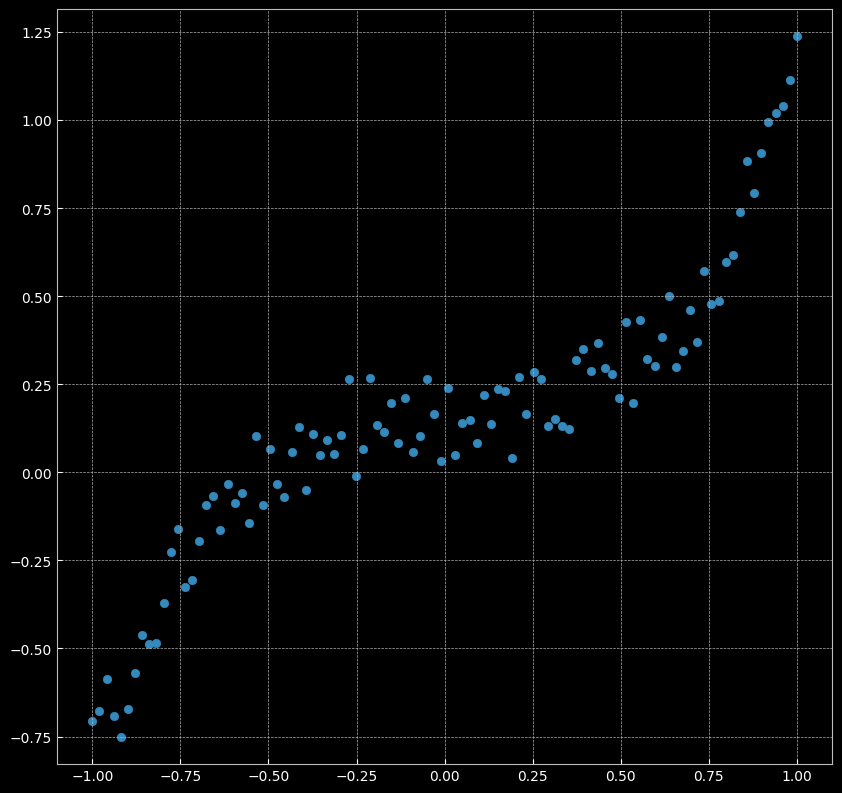

In [8]:
# visualise the data
plt.scatter(X.cpu().numpy(), y.cpu().numpy())
plt.axis("equal");

This type of regression problem which can’t be solved correctly with a linear regression, but is easily solved by the neural network structure with `nn.ReLU()` and `nn.Tanh()` activation function.

## Linear Regression(affine transformation)

Remember, an affine transformation is five things: 
1. rotation
2. reflection
3. translation 
4. scaling  
5. shearing

`nn.Sequential()` is a container, which passes modules to the constructor in the order that they are added.

`nn.linear()` is miss-named as it applies an affine transformation to the incoming data: $\boldsymbol y =Wx+b$(Here, we are doing scaling and translation).



In [9]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [12]:
# create linear model without activation, each Linear module has a weight and bias
model = nn.Sequential(
  nn.Linear(D, H),
  nn.Linear(H, C),
)
model.to(device)

# use mean square error loss for our regression  task
criterion = torch.nn.MSELoss()
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

# Training
for epoch in range(1000):
  # Feed forward to get the logits
  y_pred = model(X)

  # Compute the loss and accuracy
  loss = criterion(y_pred, y)

  print(f"[EPOCH]: {epoch}, [LOSS or MSE]: {loss.item():.6f}")
  display.clear_output(wait=True)

  # zero the gradients before running the backward pass
  optimizer.zero_grad()

  # Backward pass to compute the gradient of loss w.r.t learnable params
  loss.backward()

  # Update params
  optimizer.step()

[EPOCH]: 999, [LOSS or MSE]: 0.027633


In [14]:
# Plot trained model
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=1, bias=True)
)


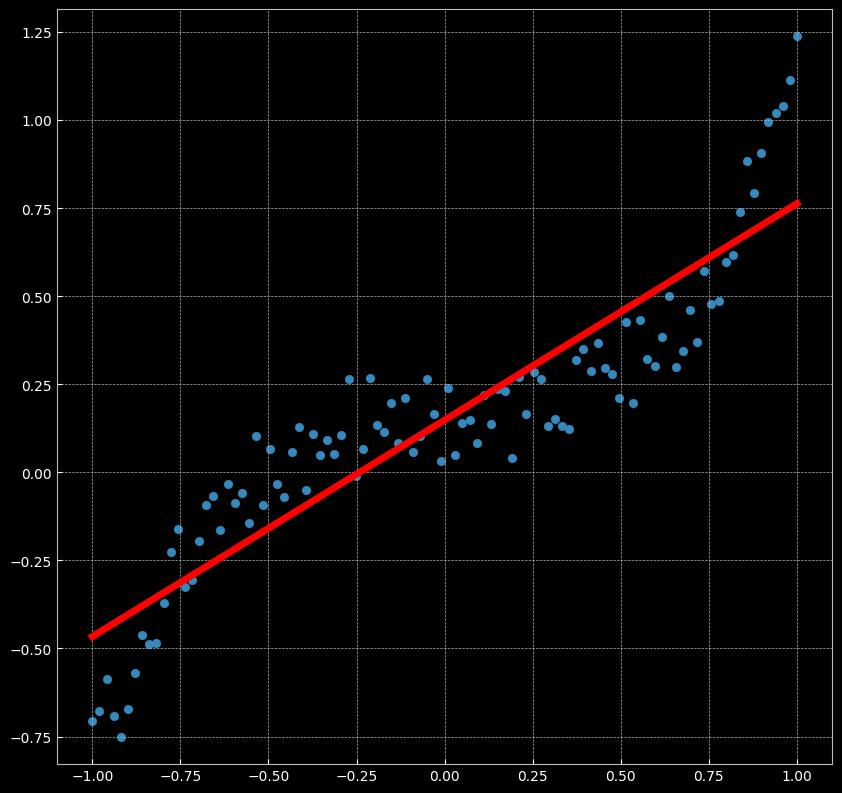

In [16]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), "r-", lw=5)
plt.axis("equal");

As it can be seen, when trying to fit the data with regression problem - only using `nn.linear()` modules, without a non-linearity between them - is impossible to us.

##Non-Linear Regression(non-linear transformation)

When we go from a linear model to one with two `nn.linear()` modules and a `nn.ReLU()` between them, then the model fit the data smoothly. 

This is because the regression become non-linear and adapt much better to this form of the data.

In [17]:
# Number of networks
n_networks = 10
models = list()
y_pretrain = list()

# use MSE for a regression task
criterion = torch.nn.MSELoss()

# create linear model with activation, each Linear module has a weight and bias
for mod in range(n_networks):
  model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU() if mod < n_networks // 2 else nn.Tanh(),
    nn.Linear(H, C),
  )
  model.to(device)

  # Append models
  models.append(model)

  # ADAM for our parameter updates
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

  # Training
  for epoch in range(1000):
    # Feed forward to get the logits
    y_pred = model(X)

    # Append pre-train output
    if epoch == 0:
      y_pretrain.append(y_pred.detach())

    # Compute the loss and accuracy
    loss = criterion(y_pred, y)

    print(f"[MODEL]: {mod + 1}, [EPOCH]: {epoch}, [LOSS]: {loss.item():.6f}")
    display.clear_output(wait=True)

    # zero the gradients before running the backward pass
    optimizer.zero_grad()

    # Backward pass to compute the gradient of loss w.r.t learnable params
    loss.backward()

    # Update params
    optimizer.step()

[MODEL]: 10, [EPOCH]: 999, [LOSS]: 0.009617


In [18]:
# Plot trained model
print(models[0], models[-1])

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
) Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


##Predictions: Before Training

##Predictions: After Training

##PyTorch 5 fundamental training steps

To train any Neural Network using PyTorch, you need 5 fundamental steps in the training loop:

1. `output = model(input)` is the model’s forward pass, which takes the input and generates the output.
2. `J = loss(output, target <or> label)` takes the model’s output and calculates the training loss with respect to the true target or label.
3. `model.zero_grad()` cleans up the gradient calculations, so that they are not accumulated for the next pass.
4. `J.backward()` does back-propagation and accumulation: It computes $\nabla_\texttt{x} J$ for every variable $\texttt{x}$ for which we have specified `requires_grad=True`. These are accumulated into the gradient of each variable: $\texttt{x.grad} \gets \texttt{x.grad} + \nabla_\texttt{x} J$.
5. `optimiser.step()` takes a step in gradient descent: $\vartheta \gets \vartheta - \eta\, \nabla_\vartheta J$.

When training a `NN`, it is very likely that you need these 5 steps in the order they were presented.